In [1]:
%%capture stored_output
%load_ext autoreload
%autoreload 2

In [2]:
import d3rlpy
from d3rlpy.metrics.scorer import (
    average_value_estimation_scorer,
    td_error_scorer,
    evaluate_on_environment,
    discounted_sum_of_advantage_scorer,
    initial_state_value_estimation_scorer,
)
import seaborn as sns
import pandas as pd
import itertools

import warnings

warnings.filterwarnings("ignore")

import os

os.chdir("..")

from augmentation.augmented_algos import AugmentedBCQ, AugmentedDiscreteBCQ
from augmentation import synth

In [3]:
os.environ["D4RL_SUPPRESS_IMPORT_ERROR"] = "1"

In [4]:
USE_GPU = False

REAL_RATIO = 0.5

AUGMENTATIONS = [("gaussian", {"sigma": 1e-3})] #, ("mixup", {"eps": 0.4})]
# epochs per environment or per algorithm?
ENVS = [
    {"name": "cartpole-replay", "discrete": True, "epochs": 2},
    # {"name": "door-human-v1", "discrete": False, "epochs": 50},
    # {"name": "halfcheetah-medium-replay-v0", "discrete": False, "epochs": 50},
    # {"name": "hopper-medium-replay-v0", "discrete": False, "epochs": 40},
]
ALGOS_C = [
    {
        "algo_class": AugmentedBCQ,
        "scorers": {
            "td_error": td_error_scorer,
            "value_scale": average_value_estimation_scorer,
            "advantage": discounted_sum_of_advantage_scorer,
            "initial_state_value": initial_state_value_estimation_scorer,
        },
    },
    {
        "algo_class": d3rlpy.algos.BCQ,
        "scorers": {
            "td_error": td_error_scorer,
            "value_scale": average_value_estimation_scorer,
            "advantage": discounted_sum_of_advantage_scorer,
            "initial_state_value": initial_state_value_estimation_scorer,
        },
    }
]
ALGOS_D = [
    {
        "algo_class": AugmentedDiscreteBCQ,
        "scorers": {
            "td_error": td_error_scorer,
            "value_scale": average_value_estimation_scorer,
            "advantage": discounted_sum_of_advantage_scorer,
            "initial_state_value": initial_state_value_estimation_scorer,
        },
    },
    {
        "algo_class": d3rlpy.algos.DiscreteBCQ,
        "scorers": {
            "td_error": td_error_scorer,
            "value_scale": average_value_estimation_scorer,
            "advantage": discounted_sum_of_advantage_scorer,
            "initial_state_value": initial_state_value_estimation_scorer,
        },
    }
]

## Training with clean and augmented datasets

In [5]:
results = []
# TODO save best models
for env_item in ENVS:
    try:
        dataset, env = d3rlpy.datasets.get_dataset(env_item["name"])
    except ValueError:
        try:
            dataset, env = d3rlpy.datasets.get_d4rl(env_item["name"])
        except ValueError:
            continue
    try_algos = ALGOS_D if env_item["discrete"] else ALGOS_C
    for algo_item in try_algos:
        algo = algo_item["algo_class"]
        agent = algo(use_gpu=USE_GPU,augmentations=AUGMENTATIONS, real_ratio= REAL_RATIO)
        metrics = agent.fit(
            dataset=dataset,
            eval_episodes=dataset,
            n_epochs=env_item["epochs"],
            scorers=(
                algo_item["scorers"]
                | {"environment_reward": evaluate_on_environment(env, n_trials=2)}
            ),
            verbose=False,
            experiment_name="{}_{}_{}_clean".format(
                env_item["name"], algo.__name__, env_item["epochs"]
            )
        )
        # easy pandasify
        for epoch, metric in metrics:
            results.append(
                {
                    "env": env_item["name"],
                    "algo": "{}_clean".format(algo.__name__),
                    "epoch": epoch,
                }
                | metric
            )

TypeError: LearnableBase.fit() got an unexpected keyword argument 'real_ratio'

## Comparing results

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_parquet("results/simple_results.parquet")

OSError: Cannot save file into a non-existent directory: 'results'

In [ ]:
def is_outlier(s):
    q1 = s.quantile(0.05)
    q3 = s.quantile(0.95)
    irq = q3 - q1
    lower_limit = q1 - 1.5 * irq
    upper_limit = q3 + 1.5 * irq
    return ~s.between(lower_limit, upper_limit)

In [ ]:
results_df = pd.read_parquet("results/cloud_results_31052022.parquet")

### TD error

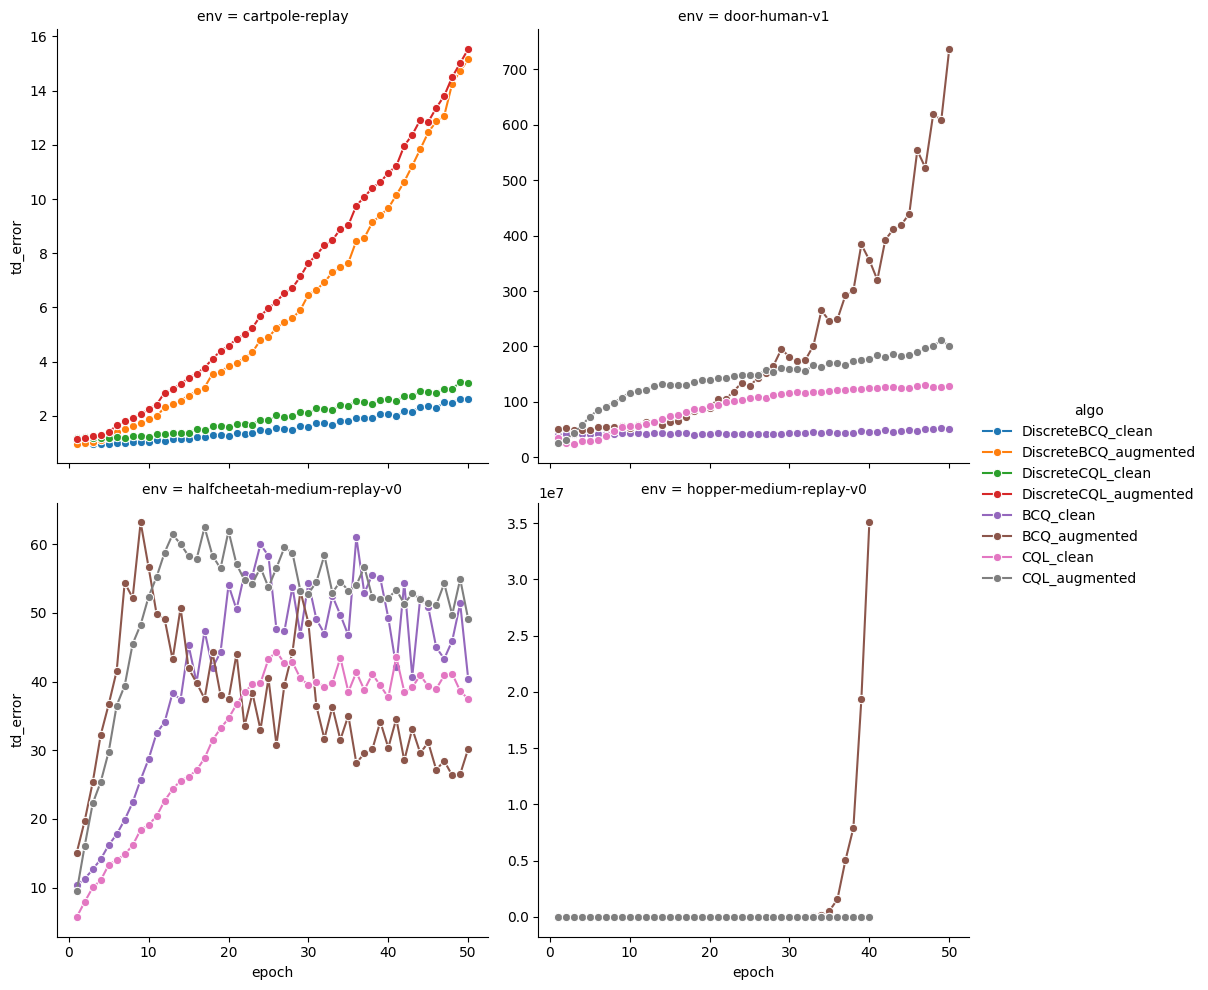

In [ ]:
results_td = results_df[["env", "algo", "epoch", "td_error"]].dropna()
g = sns.FacetGrid(
    results_td,
    col="env",
    hue="algo",
    col_wrap=2,
    height=5,
    legend_out=True,
    sharey=False,
)
g.map_dataframe(sns.lineplot, "epoch", "td_error", marker="o")
g.add_legend()

### Expected value

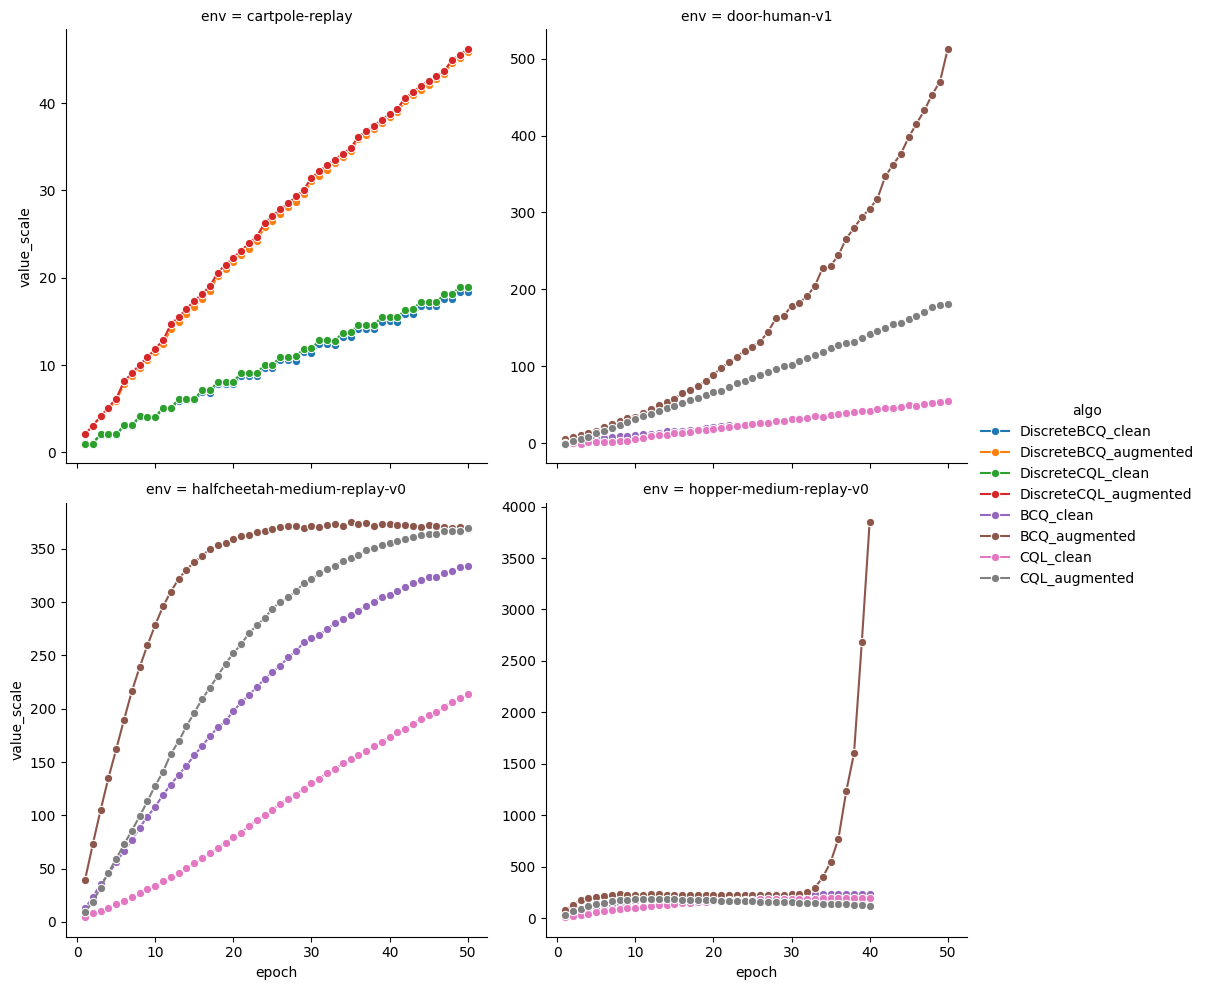

In [ ]:
results_value = results_df[["env", "algo", "epoch", "value_scale"]].dropna()
g = sns.FacetGrid(
    results_value,
    col="env",
    hue="algo",
    col_wrap=2,
    height=5,
    legend_out=True,
    sharey=False,
)
g.map_dataframe(sns.lineplot, "epoch", "value_scale", marker="o")
g.add_legend()

### Environment reward

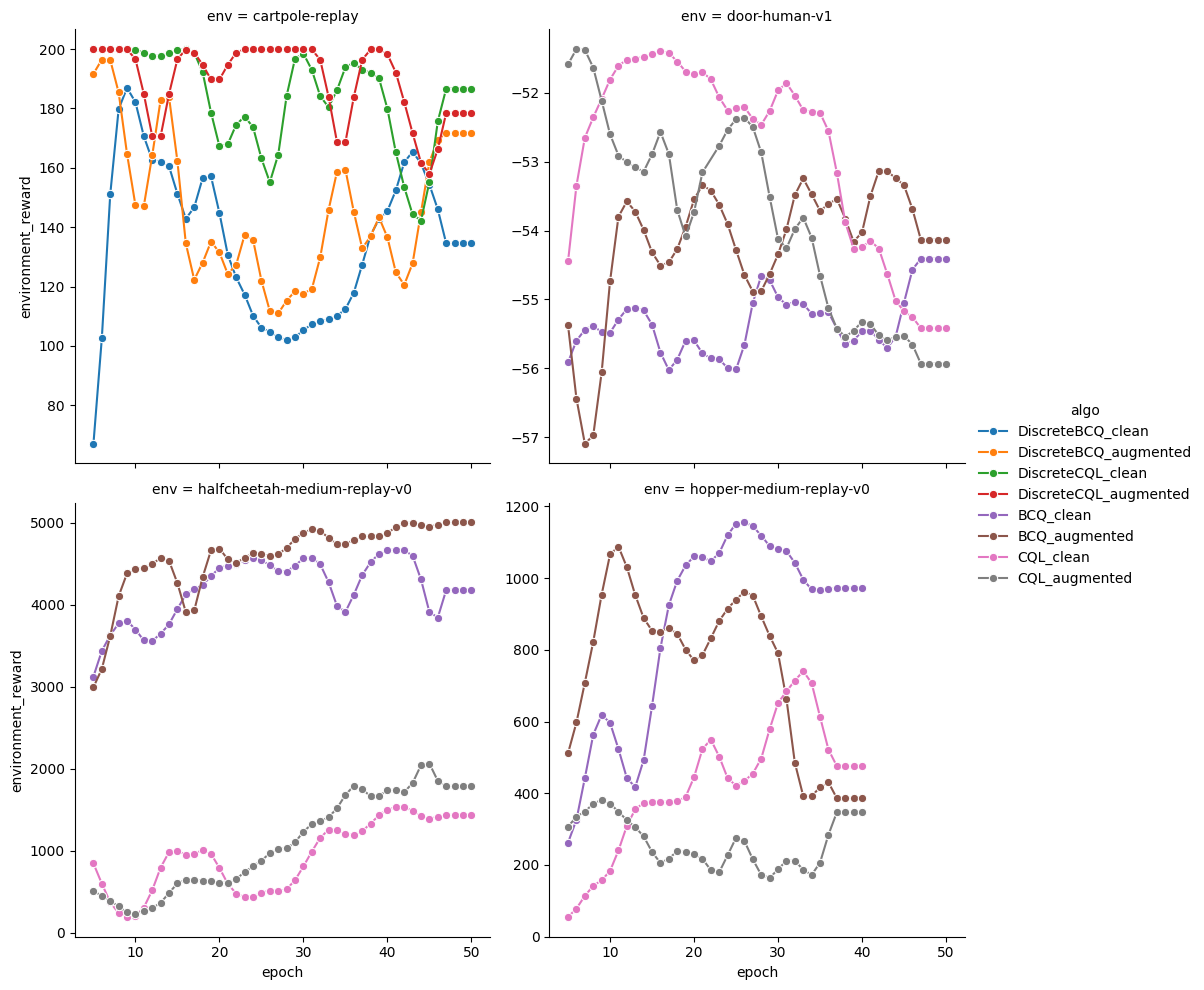

In [ ]:
results_reward = results_df[["env", "algo", "epoch", "environment_reward"]].dropna()

# remove outliers
results_reward = results_reward[
    ~results_reward.groupby(["env", "algo"])["environment_reward"].apply(is_outlier)
]
# moving average
results_reward["environment_reward"] = results_reward.groupby(["env", "algo"])[
    "environment_reward"
].transform(lambda s: s.rolling(8, center=True, win_type="parzen").mean().interpolate())

g = sns.FacetGrid(
    results_reward,
    col="env",
    hue="algo",
    col_wrap=2,
    height=5,
    legend_out=True,
    sharey=False,
)
g.map_dataframe(sns.lineplot, "epoch", "environment_reward", marker="o")
g.add_legend()

### Advantage

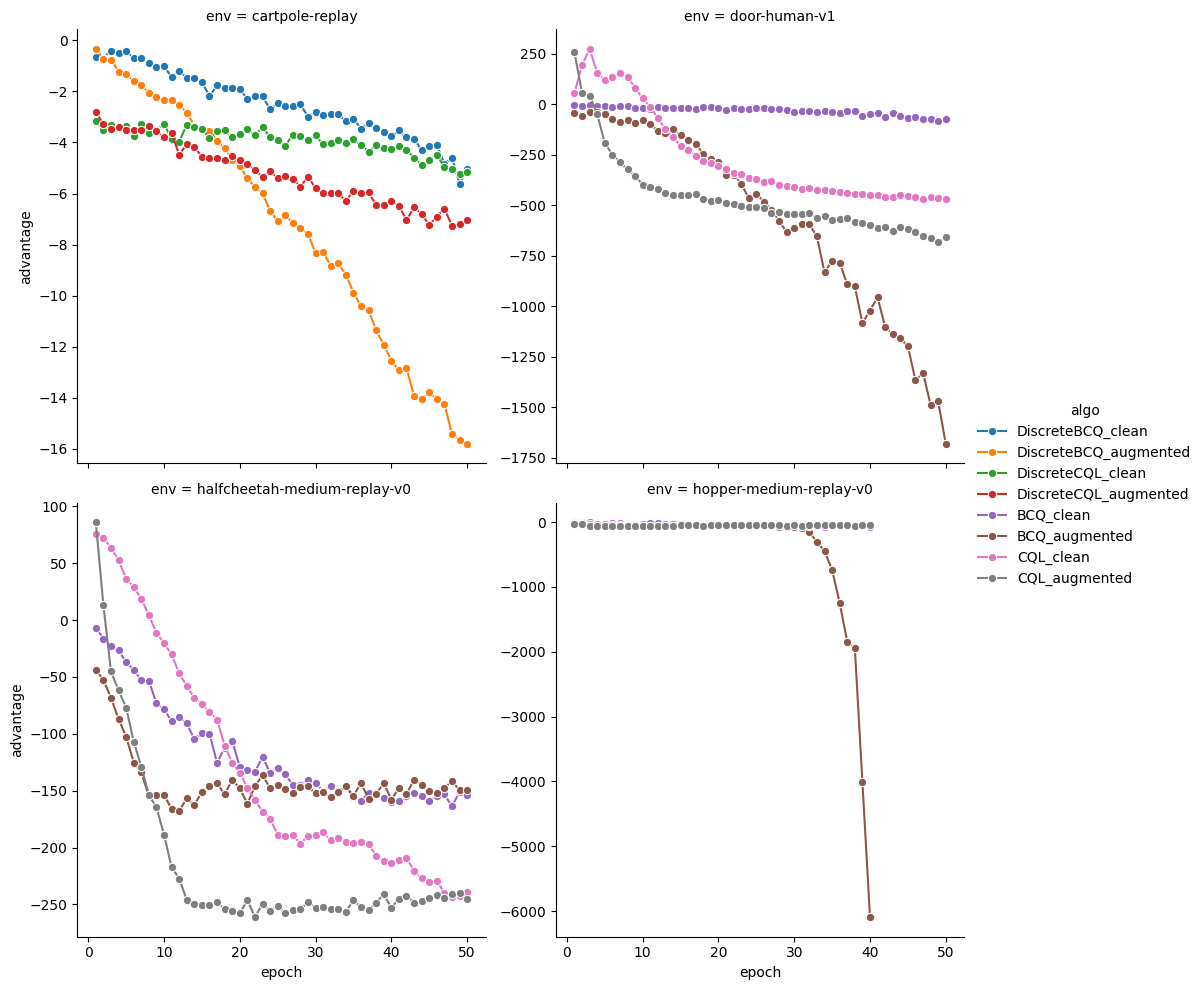

In [ ]:
results_advantage = results_df[["env", "algo", "epoch", "advantage"]].dropna()
g = sns.FacetGrid(
    results_advantage,
    col="env",
    hue="algo",
    col_wrap=2,
    height=5,
    legend_out=True,
    sharey=False,
)
g.map_dataframe(sns.lineplot, "epoch", "advantage", marker="o")
g.add_legend()